In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Activation, Rescaling
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from pathlib import Path
import cv2
import os
import warnings
import pandas as pd
from collections import deque
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers
from keras import backend as K

In [2]:
# hyperparameters
batch_size = 32
lr = 0.0001
imgSize = 150
epochs = 20
numTrainSamples = 1000  # Change later on
numValSamples = 100  # Change later on
LABEL = ["Normal", "Pneumonia"]

Text(0.5, 1.0, 'Label Distribution')

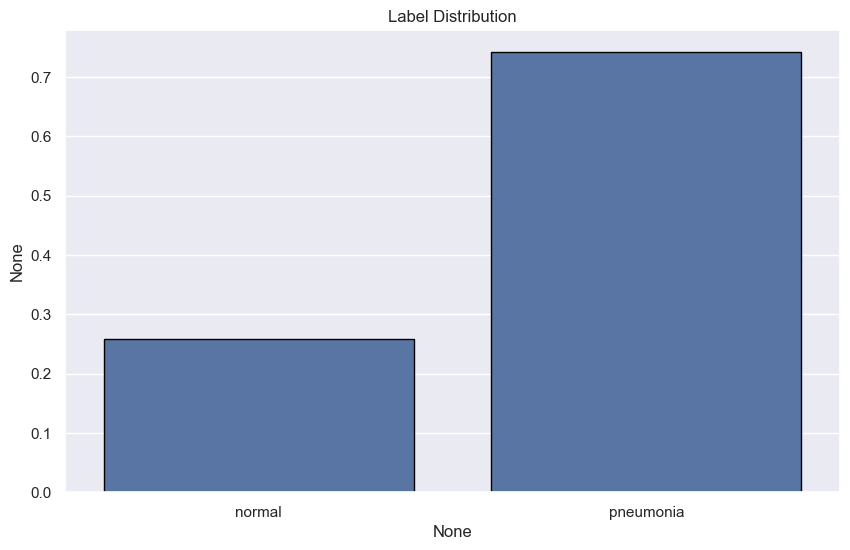

In [3]:
data_dir = Path("kaggle/input/pneumonia-xray-images")
train = data_dir / "train"
val = data_dir / "val"
test = data_dir / "test"

normal = train / "normal"
pneumonia = train / "opacity"


normalFreq = sum(1 for _ in normal.glob("*.jpeg"))
pneumoniaFreq = sum(1 for _ in pneumonia.glob("*.jpeg"))

numTrainSamples = normalFreq + pneumoniaFreq
numValSamples = sum(1 for _ in val.glob("**/*.jpeg"))


pos = sum(1 for _ in (val / "opacity").glob("**/*.jpeg")) + sum(1 for _ in (train / "opacity").glob("**/*.jpeg")) + sum(1 for _ in (test / "opacity").glob("**/*.jpeg"))
neg = sum(1 for _ in (val / "normal").glob("**/*.jpeg")) + sum(1 for _ in (train / "normal").glob("**/*.jpeg")) + sum(1 for _ in (test / "normal").glob("**/*.jpeg"))


labels = pd.Series([*[0]*normalFreq, *[1]*pneumoniaFreq])

sns.set()
fig, ax = plt.subplots(1, figsize=(10,6))
vc = labels.value_counts(normalize=True, sort=False)
labels = pd.Series(vc.values, index=["normal", "pneumonia"])
# labels
count = sns.barplot(x=labels.index, y=labels, edgecolor="black", ax=ax)
count.set_title("Label Distribution")

# plt.savefig("out/proportions.jpg")


In [4]:
train_filenames = tf.io.gfile.glob(str(train / Path('*/*')))
val_filenames = tf.io.gfile.glob(str(val / Path('*/*')))
test_filenames = tf.io.gfile.glob(str(test / Path('*/*')))


train_list = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list = tf.data.Dataset.from_tensor_slices(test_filenames)


In [5]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label = 0 if parts[-2] == "normal" else 1
    return label


def decode(img):
    # Change image to grayscale and resize it    
    img = tf.image.decode_jpeg(img, channels=1)
    return tf.image.resize(img, (imgSize, imgSize))


def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode(img)
    return img, label



train_ds = train_list.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

val_ds = val_list.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = test_list.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)


In [6]:
X_train = []
Y_train = []

X_val = []
Y_val = []

X_test = []
Y_test = []

for image, label in train_ds:
    # print(label.numpy().shape)
    X_train.append(image)
    Y_train.append(label)
    
    
for image, label in val_ds:
    X_val.append(image)
    Y_val.append(label)
    
for image, label in test_ds:
    X_test.append(image)
    Y_test.append(label)
    
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_val, Y_val = np.array(X_val), np.array(Y_val)
X_test, Y_test = np.array(X_test), np.array(Y_test)

print(len(X_train), len(X_val), len(X_test))


4192 1040 624


Found 4192 images belonging to 2 classes.


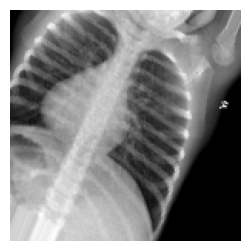

In [32]:

# Data Augmentation
# Creating an ImageGenerator
data_gen = ImageDataGenerator(rescale=1./255,   # Rescale from 0-255 to 0-1
                                   rotation_range=30,  # rondomly rotate training iamges by 30
                                   width_shift_range=0.1,  # randomly shift images horizontally by 10% of width
                                   height_shift_range=0.1,   # randomly shift images horizontally by 10% of height
                                   zoom_range=0.2,  # Randomly zoom in/out 20% into image
                                   horizontal_flip=True)  # Randomly flip image horizontally


data_gen_test = ImageDataGenerator(rescale=1./255)

training_gen = data_gen.flow_from_directory(train, color_mode="grayscale", target_size=(imgSize, imgSize), batch_size=batch_size, class_mode="binary")

# Visualizing the outputs of the generators

fig, axs = plt.subplots(1,1, figsize=(10,3))
# fig.suptitle("Generated Training Images")
generated = next(training_gen)
images = generated[0]
axs.imshow(images[0], cmap="gray")
# for i, ax in enumerate(axs):
#     ax.imshow(images[i], cmap="gray")
axs.axis('off')
    
fig.savefig("out/augmented.jpg")



In [10]:
# Defining metrics we are going to use to track our performance
# We are using these metrics as they better represent our model's generalization compared
# to the traditional accuracy score

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [55]:
model = keras.models.Sequential()

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape =(imgSize,imgSize,1)))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), activation='relu', padding = 'same' ,))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding = 'same' ,))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu', padding = 'same' ,))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy', f1_m,precision_m, recall_m, tf.keras.metrics.AUC()])
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 75, 75, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                      

In [56]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

class_weights = {
    0: 1,
    1: 4
}
checkpoint = tf.keras.callbacks.ModelCheckpoint("saved_models/checkpoint.keras", 
                    monitor="val_loss", mode="auto", 
                    save_best_only=True, verbose=0)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', baseline=None, verbose=1, patience=5)
history = model.fit(data_gen.flow(X_train, Y_train, batch_size=batch_size), epochs = epochs ,validation_data = data_gen.flow(X_val, Y_val), class_weight=class_weights,callbacks = [learning_rate_reduction, checkpoint, early_stopping])


Epoch 1/20
131/131 [==============================] - 15s 98ms/step - loss: 0.5719 - accuracy: 0.8263 - f1_m: 0.8915 - precision_m: 0.8253 - recall_m: 0.9752 - auc_5: 0.9140 - val_loss: 4.9766 - val_accuracy: 0.7433 - val_f1_m: 0.8513 - val_precision_m: 0.7434 - val_recall_m: 1.0000 - val_auc_5: 0.5000 - lr: 0.0010
Epoch 2/20
131/131 [==============================] - 11s 84ms/step - loss: 0.4132 - accuracy: 0.8771 - f1_m: 0.9211 - precision_m: 0.8717 - recall_m: 0.9819 - auc_5: 0.9592 - val_loss: 4.2449 - val_accuracy: 0.7433 - val_f1_m: 0.8506 - val_precision_m: 0.7424 - val_recall_m: 1.0000 - val_auc_5: 0.5000 - lr: 0.0010
Epoch 3/20
131/131 [==============================] - 11s 81ms/step - loss: 0.3582 - accuracy: 0.9036 - f1_m: 0.9377 - precision_m: 0.8959 - recall_m: 0.9864 - auc_5: 0.9665 - val_loss: 5.2651 - val_accuracy: 0.7433 - val_f1_m: 0.8503 - val_precision_m: 0.7424 - val_recall_m: 1.0000 - val_auc_5: 0.5000 - lr: 0.0010
Epoch 4/20
131/131 [=============================

In [57]:
# model.load_weights("saved_models/checkpoint.keras")
loss, accuracy, f1_score, precision, recall, AUC = model.evaluate(data_gen_test.flow(X_test, Y_test))
print(loss, accuracy, f1_score, precision, recall, AUC)


20/20 [==============================] - 1s 23ms/step - loss: 0.2954 - accuracy: 0.9022 - f1_m: 0.9235 - precision_m: 0.8959 - recall_m: 0.9568 - auc_5: 0.9565
0.29542285203933716 0.9022436141967773 0.9234938621520996 0.8958841562271118 0.9567567110061646 0.9565252065658569


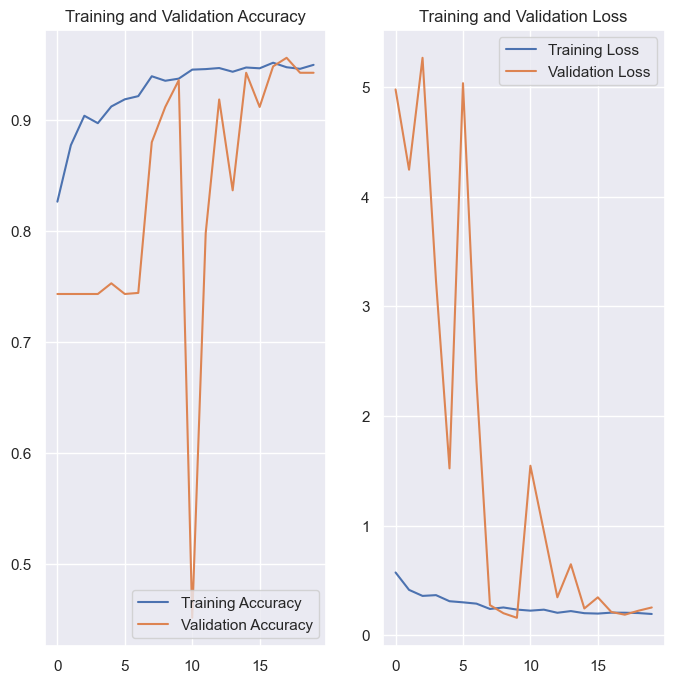

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

eRange = epochs
if early_stopping.stopped_epoch:
    eRange = early_stopping.stopped_epoch+1
    
epochs_range = range(eRange)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')\

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

20/20 [==============================] - 0s 22ms/step


<Axes: >

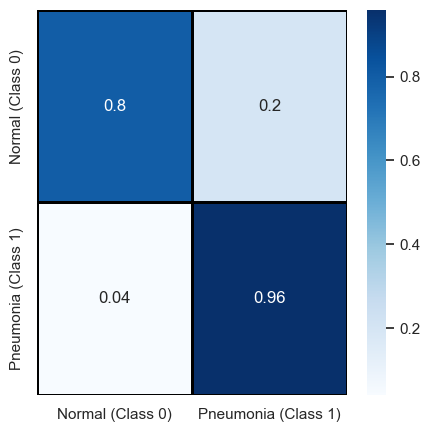

In [40]:
# model.load_weights("saved_models/Possible_Final_Recall_Update.keras")
classes = ['Normal (Class 0)','Pneumonia (Class 1)']
predictions = model.predict(X_test / 255.)
predictions = predictions.reshape(1,-1)[0]
predictions = np.round(predictions)
cm = confusion_matrix(Y_test.astype(int), predictions, normalize='true')
cm = pd.DataFrame(np.round(cm, decimals=2) , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = classes,yticklabels = classes)
# plt.savefig("./out/Confusion Matrix Unbiased.png")